In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import h5py
from struct import *
import math

In [3]:
mode, idx = 'train', 3

img_path  = 'F:/research/NYUCADrender/NYUCAD%s_images/NYU%04d_0000' % (mode,idx)
clip      = cv2.imread(img_path + '_clip.png', -1)
instance  = cv2.imread(img_path + '_instance.png', -1)
label     = cv2.imread(img_path + '_labels.png', -1)
suncg     = cv2.imread(img_path + '_labels_suncg.png', -1)

mat_path  = 'F:/research/NYUCADrender/NYUCAD%s_amodal_depth/NYU%04d_0000' % (mode,idx)
mat       = mat_path + '_amodal_depths.mat'

bin_path  = 'F:/research/sscnet/depthbin_eval/depthbin/NYUCAD%s/NYU%04d_0000' % (mode,idx)
_bin      = bin_path + '.bin'
_depth    = bin_path + '.png'

# ovoxel - tsdf generated from original depth map
# avoxel - tsdf generated from amodal surfaces
ovoxel_path = 'F:/research/datasets/NYUCADedge/NYUCAD%s/NYU%04d_0000' % (mode,idx)
_ovoxel     = ovoxel_path + '.npz'

avoxel_path = 'F:/research/datasets/NYUCADamodal/NYUCAD%s_amodal/NYU%04d_0000' % (mode,idx)
_avoxel     = avoxel_path + '.npz'


In [2]:
def get_bin_info(bin_file):
    with open(bin_file,'rb') as f:
        float_size = 4
        cor = f.read(float_size*3)
        cors = unpack('fff',cor)
        # print('Origin in world coordinates\\n',cors)
        cam = f.read(float_size*16)
        cams = unpack('ffffffffffffffff', cam)
        # print('Camera pose %16f\\n',cams)
        f.close()

    return cors, cams


def read_bitshift(depth_path, return_flat=False, return_float=False):
    depth = cv2.imread(depth_path, -1)
    lower_depth = depth >> 3
    higher_depth = (depth % 8) << 13
    real_depth = (lower_depth | higher_depth)

    if return_flat:
        real_depth = np.reshape(real_depth, (-1,))

    if return_float:
        real_depth = real_depth.astype(np.float32)/1000

    return real_depth


def read_mat(mat_file, return_flat=True, return_float=False):
    with h5py.File(mat_file, 'r') as f:
        data = f['depth_mat']
        amodal_list = []
        for i in data:
            depth = np.transpose(i, (1,0))
            depth = np.ceil(depth*1000).astype(np.uint16)
            
            if return_float == True:
                depth = depth.astype(np.float32)/1000
                
            if return_flat == True:
                depth = np.reshape(depth, (-1,))
            
            amodal_list.append(depth)
        f.close()
    amodal_list = np.array(amodal_list)
    
    return amodal_list


def calculate_mapping_vectorize(bin_file, depth_img):
    # parameters
    img_height, img_width = (480, 640)
    img_scale = 1.0
    vox_unit = 0.02
    vox_size = (240,144,240)
    cam_K = np.array([518.8579 / img_scale, 0., img_width / (2 * img_scale),
                      0., 518.8579 / img_scale, img_height / (2 * img_scale),
                      0., 0., 1.], dtype=np.float32)
    
    vox_origin, cam_pose = get_bin_info(bin_file)
    
    # real_depth = np.reshape(depth_img_flat, (img_height, img_width))
    
    # depth_mapping = np.ones((img_height, img_width), dtype=np.uint64) * -1
    
    real_depth = depth_img
    
    img_y = np.repeat(np.expand_dims(np.arange(real_depth.shape[0]), axis=1), real_depth.shape[1], axis=1)
    img_x = np.repeat(np.expand_dims(np.arange(real_depth.shape[1]), axis=0), real_depth.shape[0], axis=0)

    point_cam_x = (img_x - cam_K[2]) * real_depth / cam_K[0]
    point_cam_y = (img_y - cam_K[5]) * real_depth / cam_K[4]
    point_cam_z = real_depth

    point_base_x = cam_pose[0 * 4 + 0] * point_cam_x + cam_pose[0 * 4 + 1] * point_cam_y + cam_pose[0 * 4 + 2] * point_cam_z
    point_base_y = cam_pose[1 * 4 + 0] * point_cam_x + cam_pose[1 * 4 + 1] * point_cam_y + cam_pose[1 * 4 + 2] * point_cam_z
    point_base_z = cam_pose[2 * 4 + 0] * point_cam_x + cam_pose[2 * 4 + 1] * point_cam_y + cam_pose[2 * 4 + 2] * point_cam_z

    point_base_x = point_base_x + cam_pose[0 * 4 + 3]
    point_base_y = point_base_y + cam_pose[1 * 4 + 3]
    point_base_z = point_base_z + cam_pose[2 * 4 + 3]

    z = np.floor((point_base_x - vox_origin[0]) / vox_unit)
    x = np.floor((point_base_y - vox_origin[1]) / vox_unit)
    y = np.floor((point_base_z - vox_origin[2]) / vox_unit)

    z = z.astype(np.int)
    x = x.astype(np.int)
    y = y.astype(np.int)
    
    # some voxels may be out of range in certain dimensions and need to be eliminated from further processing
    lower_limit, upper_limit = np.where(z < 0), np.where(z >= vox_size[2]) # out of range in z-axis # might have error where no voxels are out of range in z-axis first
    z[lower_limit], x[lower_limit], y[lower_limit] = -1, -1, -1
    z[upper_limit], x[upper_limit], y[upper_limit] = -1, -1, -1
    
    lower_limit, upper_limit = np.where(y < 0), np.where(y >= vox_size[1]) # out of range in y-axis
    z[lower_limit], x[lower_limit], y[lower_limit] = -1, -1, -1
    z[upper_limit], x[upper_limit], y[upper_limit] = -1, -1, -1
    
    lower_limit, upper_limit = np.where(x < 0), np.where(x >= vox_size[0]) # out of range in x-axis
    z[lower_limit], x[lower_limit], y[lower_limit] = -1, -1, -1
    z[upper_limit], x[upper_limit], y[upper_limit] = -1, -1, -1
    
    return np.stack((x,y,z), axis=-1)

In [9]:
# Convert GT depth to occupancy grids
mode = 'test'
bin_path = '/home/mmu/Downloads/sscnet/depthbin_eval/depthbin/NYUCAD%s/' % mode
img_path = '/home/mmu/Downloads/NYUCAD%s_render_images/' % mode
mat_path = '/home/mmu/Downloads/NYUCAD%s_amodal_depth/' % mode

for filename in sorted(os.listdir(bin_path)):
    if filename.endswith('.bin'):
        if filename != 'NYU0298_0000.bin':
            continue
        print(filename)
        
#         if filename != 'NYU0087_0000'
        # '_clip.png' is basically instance image but it's clipped in accordance to original depth image
        # an example to illustrate this is NYUCADtrain-NYU0112_0000.png. 
        # to-do: maybe modify in matlab to exclude directly during render stage
        # note: obtain amodal depth maps indexed by '_clip.png'. sometimes mesh models like floor 
        # is available in .mat but it's completely occluded in instance image and shud not be included in further operations
        clip = os.path.join(img_path, filename[:-4] + '_clip.png')
        clip = cv2.imread(clip, -1)
        
        instances = np.unique(clip)
        if instances[0] == 0:
            instances = instances[1:]
        # print("Instances:", instances)
        
        # Read .mat file for amodal depths
        # note: amodal depths are already clipped because they are rendered with the same camera parameters
        # as the final depth map
        mat = os.path.join(mat_path, filename[:-4] + '_amodal_depths.mat')
        _amodal_list = read_mat(mat, return_flat=False, return_float=True)
        
        depth_list = []
        for i in instances: # instances start with 1, amodal_list starts with 0
            iidx = i - 1
            depth_list.append(_amodal_list[iidx])
        # print("No. of depth maps:", len(depth_list))
        
        # ensure that depth map is in floating point
        occupancy_scene = np.ones((240,144,240), dtype=np.float32) * -1
        _bin = os.path.join(bin_path, filename[:-4] + '.bin')
        for i in range(len(depth_list)):
            mapping = calculate_mapping_vectorize(_bin, depth_list[i])    
            mapping = np.reshape(mapping, (-1,3)) # flatten for easier indexing

            # invalid voxels are marked out with '-1'
            for j in np.where(mapping[:,0] != -1)[0]:
                x, y, z = mapping[j,0], mapping[j,1], mapping[j,2]
                occupancy_scene[z,y,x] = 1 # flip to align with depth map
        occupancy_scene[occupancy_scene == -1] = 0

        # amoc = amodal occupancy
        output_folder = '/home/mmu/Downloads/NYUCADoccupancy/NYUCAD%s/' % mode
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        output_name = os.path.join(output_folder, filename[:-4] + '_amoc.npz')
        print(output_name)
        
        np.savez_compressed(output_name, 
                            occupancy=occupancy_scene)

NYU0298_0000.bin
/home/mmu/Downloads/NYUCADoccupancy/NYUCADtest/NYU0298_0000_amoc.npz


In [5]:
# obtain amodal depth maps indexed by instances; sometimes mesh models like floor is available in .mat but occluded in instance image\
# and shud not be included in further operations
instances = np.unique(clip)
if instances[0] == 0:
    instances = instances[1:]
print("Instances:", instances)

_amodal_list = read_mat(mat, return_flat=False, return_float=True)

depth_list = []
for i in instances: # instances start with 1, amodal_list starts with 0
    iidx = i - 1
    depth_list.append(_amodal_list[iidx])

print("No. of depth maps:", len(depth_list))

# don't forget about the clipped distances inside original depth maps
# find which scenes that exhibits such behaviors
# e.g. train, NYU0112_0000

# ensure that depth map is in floating point
occupancy_scene = np.ones((240,144,240), dtype=np.float32) * -1
for i in range(len(depth_list)):
    mapping = calculate_mapping_vectorize(_bin, depth_list[i])    
    mapping = np.reshape(mapping, (-1,3)) # flatten for easier indexing
    
    # invalid voxels are marked out with '-1'
    for j in np.where(mapping[:,0] != -1)[0]:
        x, y, z = mapping[j,0], mapping[j,1], mapping[j,2]
        occupancy_scene[z,y,x] = 1 # flip to align with depth map
occupancy_scene[occupancy_scene == -1] = 0

# amoc = amodal occupancy
output_folder = 'C:/Users/KY/sandbox/data/NYU%04d_0000_amoc.npz' % idx
np.savez_compressed(output_folder, 
                    occupancy=occupancy_scene)


Instances: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
No. of depth maps: 16


Max depth: 10.0 Min depth 0.0


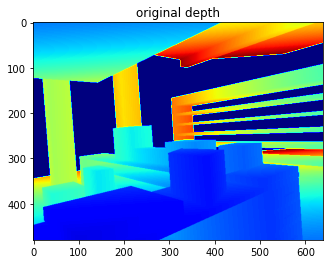

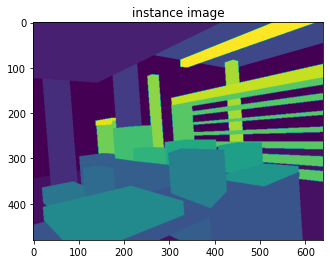

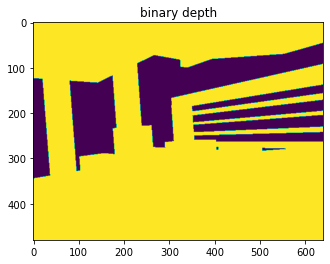

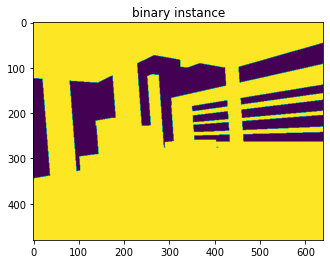

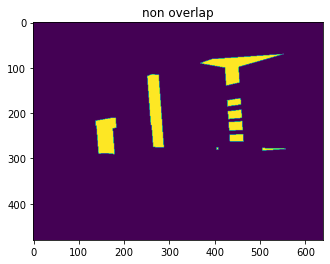

In [5]:
# Do depth clipping here

# first confirm the scenes
# confirm the clipping works
# max amodal depth cannot be farther than minimum depth being clipped
original_depth = read_bitshift(_depth, return_flat=False, return_float=False)
print("Max depth:", original_depth.max()/1000, "Min depth", original_depth.min()/1000)

plt.title('original depth'); plt.imshow(original_depth, cmap='jet'); plt.show()

plt.title('instance image'); plt.imshow(instance); plt.show()

# convert both images to binary and check for non-overlap
# then use non-overlap region and check for depth
binary_depth = original_depth.copy()
binary_depth[original_depth != 0] = 1
plt.title('binary depth'); plt.imshow(binary_depth); plt.show()

binary_instance = instance.copy()
binary_instance[instance != 0] = 1
plt.title('binary instance'); plt.imshow(binary_instance); plt.show()

non_overlap = np.logical_xor(binary_depth, binary_instance)
plt.title('non overlap'); plt.imshow(non_overlap); plt.show()

# non_overlap_depth = [SHUD BE FULLY RENDERED DEPTH] * non_overlap

In [23]:
avoxel = np.load(_avoxel)
atsdf = avoxel['tsdf']
# print(np.unique(atsdf))

# Modification 3: Foreground scaled to small values + make all values non-negative
fg = np.unique(atsdf)
for val in fg:
    if val < 0 or val == 1:
        continue
    replace = np.where(atsdf == val)
    _val = 0.99 - val
    _val = math.log(_val, 0.3)/10
    atsdf[replace] = _val

atsdf = np.abs(atsdf)

[-9.1666669e-01 -8.8214886e-01 -8.5566247e-01 -8.3333331e-01
 -8.1366098e-01 -7.9587585e-01 -7.6429772e-01 -7.5000000e-01
 -7.3647690e-01 -7.2361457e-01 -7.1132487e-01 -6.9953740e-01
 -6.8819523e-01 -6.6666663e-01 -6.5640783e-01 -6.4644659e-01
 -6.3675845e-01 -6.2732196e-01 -6.1811864e-01 -6.0913205e-01
 -5.9175169e-01 -5.8333337e-01 -5.7508171e-01 -5.6698728e-01
 -5.5123627e-01 -5.4356456e-01 -5.2859545e-01 -5.2128649e-01
 -5.1408732e-01 -5.0699329e-01 -5.0000000e-01 -4.9310309e-01
 -4.8629886e-01 -4.7295374e-01 -4.6640629e-01 -4.5993829e-01
 -4.5354682e-01 -4.4722921e-01 -4.4098300e-01 -4.3480581e-01
 -4.2264974e-01 -4.1666669e-01 -4.1074437e-01 -4.0488094e-01
 -3.9907479e-01 -3.9332420e-01 -3.8762754e-01 -3.7639040e-01
 -3.7084717e-01 -3.6535221e-01 -3.5990453e-01 -3.4914583e-01
 -3.4383267e-01 -3.3333331e-01 -3.2814521e-01 -3.2299680e-01
 -3.1788731e-01 -3.1281573e-01 -3.0778140e-01 -3.0278331e-01
 -2.9289323e-01 -2.8799969e-01 -2.8313953e-01 -2.7831215e-01
 -2.7351683e-01 -2.68752

In [32]:
mode = 'test'

avoxel_path = 'F:/research/datasets/NYUCADamodal/NYUCAD%s_amodal' % (mode)
save_path = 'F:/research/datasets/NYUCADamodal/v3/NYUCAD%s_amodal' % (mode)
if not os.path.exists(save_path):
    os.makedirs(save_path)

for file in os.listdir(avoxel_path):
    _avoxel = os.path.join(avoxel_path, file)
    # print(_avoxel)
    
    avoxel = np.load(_avoxel)
    atsdf = avoxel['tsdf']

    # Modification 3
    # 1. Foreground scaled to small values
    # 2. Background values are left as default (per distance transform calculation)
    # 3. Make all values non-negative
    fg = np.unique(atsdf)
    for val in fg:
        if val < 0 or val == 1:
            continue
        replace = np.where(atsdf == val)
        _val = 0.99 - val
        _val = math.log(_val, 0.3)/10
        atsdf[replace] = _val

    atsdf = np.abs(atsdf)
    
    _save_path = os.path.join(save_path, file)
    print("Saving to", _save_path)

    np.savez_compressed(_save_path,
                        tsdf=atsdf,
                        edges=avoxel['edges'],
                        lbl=avoxel['lbl'],
                        weights=avoxel['weights'],
                        vol=avoxel['vol'])



F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0001_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0001_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0002_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0002_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0009_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0009_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0014_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0014_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0015_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0015_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0016_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0016_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0017_0000.npz
Saving to F:/research/dat

Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0132_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0133_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0133_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0134_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0134_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0137_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0137_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0153_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0153_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0154_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0154_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0155_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0155_0000.npz
F:/research/

F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0281_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0281_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0282_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0282_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0283_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0283_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0284_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0284_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0285_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0285_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0296_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0296_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0297_0000.npz
Saving to F:/research/dat

Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0430_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0431_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0431_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0432_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0432_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0433_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0433_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0434_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0434_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0435_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0435_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0441_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0441_0000.npz
F:/research/

F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0555_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0555_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0556_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0556_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0557_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0557_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0558_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0558_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0559_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0559_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0560_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0560_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0561_0000.npz
Saving to F:/research/dat

Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0669_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0670_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0670_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0671_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0671_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0672_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0672_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0673_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0673_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0676_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0676_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0677_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0677_0000.npz
F:/research/

F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0772_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0772_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0773_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0773_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0774_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0774_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0775_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0775_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0776_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0776_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0777_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0777_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0778_0000.npz
Saving to F:/research/dat

Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0871_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0906_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0906_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0907_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0907_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0908_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0908_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0917_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0917_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0918_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0918_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU0919_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU0919_0000.npz
F:/research/

F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1053_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1053_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1057_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1057_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1058_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1058_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1075_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1075_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1076_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1076_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1077_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1077_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1078_0000.npz
Saving to F:/research/dat

Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1151_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1152_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1152_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1153_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1153_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1154_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1154_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1155_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1155_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1156_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1156_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1157_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1157_0000.npz
F:/research/

F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1247_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1247_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1248_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1248_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1249_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1249_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1250_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1250_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1254_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1254_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1255_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1255_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1256_0000.npz
Saving to F:/research/dat

Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1340_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1347_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1347_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1348_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1348_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1349_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1349_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1353_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1353_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1354_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1354_0000.npz
F:/research/datasets/NYUCADamodal/NYUCADtest_amodal\NYU1355_0000.npz
Saving to F:/research/datasets/NYUCADamodal/v3/NYUCADtest_amodal\NYU1355_0000.npz
F:/research/